In [404]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.patches as patches

import re

import seaborn as sn

%matplotlib inline

In [406]:
sn.set()

In [20]:
with open('/Users/spardy/Desktop/Congressional Biographical Directory.htm', encoding = "ISO-8859-1") as f:
    congressional_table = pd.read_html(f.read(), header=0)
    
congressional_table = congressional_table[0]

In [185]:
def get_birth_year(birth_death):
    try:
        return float(birth_death[:4])
    except (ValueError, TypeError):
        return np.nan


In [119]:
def running_median(x, width, upper=90, lower=10):
    if width % 2 == 0:
        width += 1
    
    N = width // 2
    
    def make_window(x, i):
        ln = len(x)
        start = i - N if i > N else 0
        end = i + N if i < ln - N else ln
        return x[start:end]
    
    medians = np.empty_like(x)
    upper_perc = np.empty_like(x)
    lower_perc = np.empty_like(x)
    
    for i in range(len(x)):
        window = make_window(x, i)
        medians[i] = np.median(window)
        upper_perc[i] = np.percentile(window, upper)
        lower_perc[i] = np.percentile(window, lower)
        
    return medians, upper_perc, lower_perc
    

In [349]:
ages_when_entering = np.array([])
years_entered = np.array([])
years_left = np.array([])
terms = np.array([])

data = {'age': 0, 'entered': 0, 'terms': 0, 'left': 0}

for entry in congressional_table.iterrows():
    
    info = entry[1]
    if info['Member Name'] is np.nan:  # second plus term
        data['terms'] += 1

        m = re.search('[0-9]{4}-([0-9]{4})', info['Congress(Year)'])
        if m is not None:
            data['left'] = int(m.groups()[0])
        else:
            pass
        
    else:  # first term
        if data['terms'] > 0:  # we have hit a new senator
            years_entered = np.append(years_entered, data['entered'])
            ages_when_entering = np.append(ages_when_entering, data['age'])
            terms = np.append(terms, data['terms'])
            years_left = np.append(years_left, data['left'])
            data = {'age': 0, 'entered': 0, 'terms': 0, 'left': 0}  # and reset the data

        birth_death = info['Birth-Death']
        birth_year = get_birth_year(birth_death)
        if birth_year is np.nan:
            continue
        
        m = re.search('([0-9]{4})', info['Congress(Year)'])
        if m is not None:
            year_entered = int(m.groups()[0])
        else:
            continue
            
        m = re.search('[0-9]{4}-([0-9]{4})', info['Congress(Year)'])
        if m is not None:
            year_left = int(m.groups()[0])
        else:
            year_left = 0
            
        data['terms'] += 1
        data['age'] = year_entered - birth_year
        data['entered'] = year_entered
        data['left'] = year_left
        
good_data, = np.where(years_entered != 0)
years_entered = years_entered[good_data]
ages_when_entering = ages_when_entering[good_data]
years_left = years_left[good_data]
terms = terms[good_data]

In [350]:
years_sort = np.argsort(years_entered)
avg, upper, lower = running_median(ages_when_entering[years_sort], 100, upper=75, lower=25)

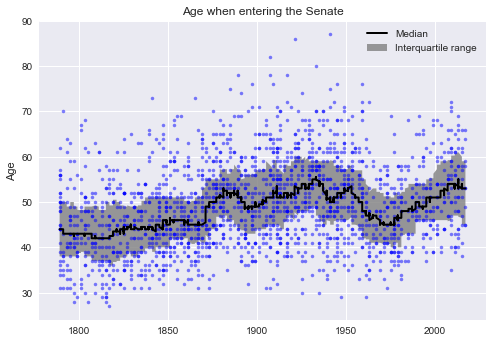

In [431]:
fig, axis = plt.subplots(1)
axis.plot(years_entered[years_sort], ages_when_entering[years_sort], 'b.', alpha=0.5)

axis.plot(years_entered[years_sort], avg, 'k-', linewidth=2, label='Median')

axis.fill_between(years_entered[years_sort], upper, lower,
                  facecolor='gray', interpolate=True, alpha=0.8, label='Interquartile range')

axis.legend()

axis.set_ylabel('Age')
axis.set_title('Age when entering the Senate')
fig.savefig('Age_when_entering.jpeg', dpi=100)

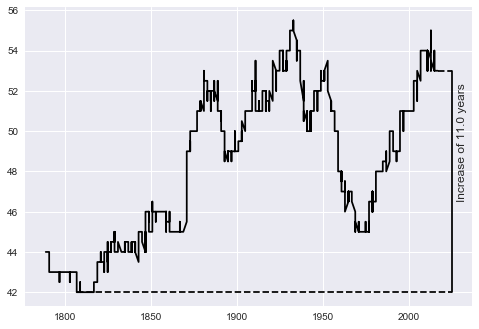

In [408]:
date_ = years_entered[years_sort]

fig, axis = plt.subplots(1)

axis.plot(date_, avg, 'k-')

where_min = np.argmin(avg)
where_max = -1 #np.argmax(avg)

axis.plot([date_[where_min], 2025], [avg[where_min], avg[where_min]],
          linestyle='--', color='black')
axis.plot([date_[where_max], 2025], [avg[where_max], avg[where_max]],
          linestyle='--', color='black')

axis.plot([2025, 2025], [avg[where_max], avg[where_min]], color='black')
axis.text(2028, 52, "Increase of {:1.1f} years".format((avg[where_max] - avg[where_min])),
          rotation=90)


## Num terms as a function of when entered

In [344]:
look_back = np.arange(2016, 1950, -1)
most_possible = ((2016 - np.arange(2016, 1950, -1)) // 6) + 1
num_terms = ((terms - 1)  // 3) + 1
mean_n_terms, term_year, _ = stats.binned_statistic(years_entered, num_terms, bins=np.arange(1780, 2020, 10))
range_n_terms, term_year, _ = stats.binned_statistic(years_entered, num_terms, bins=np.arange(1780, 2020, 10),
                                                     statistic=lambda x: np.percentile(x, 75) - np.percentile(x, 25))

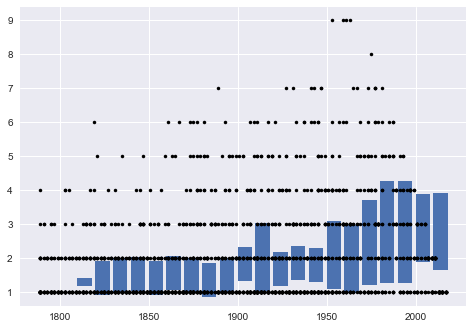

In [409]:
fig, axis = plt.subplots(1)
axis.plot(years_entered, num_terms , 'k.')
for year_, mean_, range_  in zip(term_year[1:], mean_n_terms, range_n_terms):
    axis.add_patch(patches.Rectangle((year_, mean_-range_/2.), 8, range_) )
        

## Num terms as function of when left (or current)

In [387]:
num_terms = ((terms - 1)  // 3) + 1
median_n_terms, term_year, _ = stats.binned_statistic(years_left, num_terms, bins=np.arange(1780, 2020, 10),
                                                    statistic='median')
range_n_terms, term_year, _ = stats.binned_statistic(years_left, num_terms, bins=np.arange(1780, 2020, 10),
                                                     statistic=lambda x: np.percentile(x, 75) - np.percentile(x, 25))

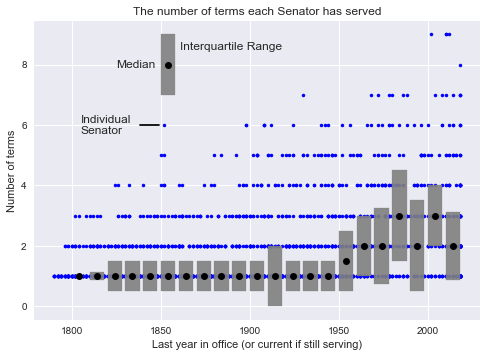

In [432]:
fig, axis = plt.subplots(1)
for year_, median_, range_  in zip(term_year[1:], median_n_terms, range_n_terms):
    axis.plot(year_+4, median_, 'ko', zorder=4)
    axis.add_patch(patches.Rectangle((year_, median_-range_/2.), 8, range_, alpha=0.9, color='gray', zorder=2))

axis.plot(years_left, num_terms , 'b.', zorder=1)

##
    
median_ = 8
range_ = 2
year_ = 1850

axis.plot(year_+4, median_, 'ko')
axis.add_patch(patches.Rectangle((year_, median_-range_/2.), 8, range_, alpha=0.9, color='gray'))
    
axis.text(year_-25, median_-0.1, 'Median')
axis.text(year_+11, median_+0.5, 'Interquartile Range')

axis.plot([1838, 1849], [6, 6], color='black')
axis.text(1805, 5.7, 'Individual\nSenator')

axis.set_ylabel("Number of terms")
axis.set_xlabel("Last year in office (or current if still serving)")
axis.set_title("The number of terms each Senator has served")
fig.savefig('num_terms.jpeg', dpi=100)

In [232]:
congressional_table_filled = congressional_table.copy()

last_info = None

for i, entry in enumerate(congressional_table.iterrows()):
    
    info = entry[1]
    if info['Member Name'] is np.nan:  # second plus term
        congressional_table_filled.iloc[i]['Birth-Death'] = last_info['Birth-Death']
        
    else:  # first term
        last_info = info


In [238]:
def avg_age_in_congress(entry):
    m = re.search('\(([0-9]{4})-[0-9]{4}\)', entry.name)
    if m is not None:
        congress_year = float(m.groups()[0])
        
    birth_years = np.fromiter(map(get_birth_year, entry['Birth-Death']), float)
    ages = congress_year - birth_years
    return np.nanmean(ages)
    

In [239]:
def sort_congress(keyval):
    key, val = keyval
    return int(key.split('(')[0])


In [449]:
congress_date = np.array([], dtype=int)
avg_ages = np.array([])
for key, val in sorted(congressional_table_filled.groupby('Congress(Year)').apply(avg_age_in_congress).iteritems(),
                       key=sort_congress):
    congress_date = np.append(congress_date, int(key.split('(')[1].split('-')[0]))
    avg_ages = np.append(avg_ages, val)



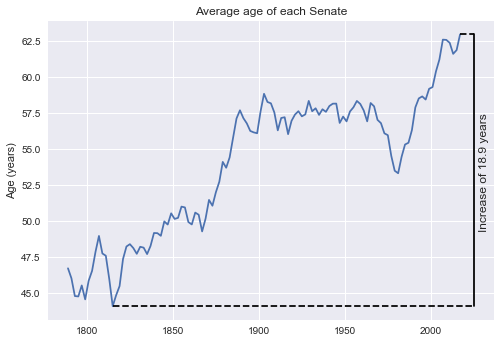

In [450]:
fig, axis = plt.subplots(1)

axis.plot(congress_date, avg_ages)

axis.set_ylabel('Age (years)')

where_min = np.argmin(avg_ages)
where_max = np.argmax(avg_ages)

axis.plot([congress_date[where_min], 2025], [avg_ages[where_min], avg_ages[where_min]],
          linestyle='--', color='black')
axis.plot([congress_date[where_max], 2025], [avg_ages[where_max], avg_ages[where_max]],
          linestyle='--', color='black')

axis.plot([2025, 2025], [avg_ages[where_max], avg_ages[where_min]], color='black')
axis.text(2028, 57, "Increase of {:1.1f} years".format((avg_ages.max() - avg_ages.min())),
          rotation=90)

axis.set_title("Average age of each Senate")
fig.savefig('avg_age_of_senate.jpeg', dpi=100)

In [436]:
congressional_table_reduced = congressional_table.copy()

last_info = None

to_delete = []

for i, entry in enumerate(congressional_table.iterrows()):
    
    info = entry[1]
    if info['Member Name'] is np.nan:  # second plus term
        n_terms += 1
        if n_terms > 6:
            to_delete.append(i)
        congressional_table_reduced.iloc[i]['Birth-Death'] = last_info['Birth-Death']
    else:  # first term
        n_terms = 1
        last_info = info

congressional_table_reduced = congressional_table_reduced.drop(congressional_table_reduced.index[to_delete])

In [447]:
congress_date_new = np.array([], dtype=int)
avg_ages_new = np.array([])
for key, val in sorted(congressional_table_reduced.groupby('Congress(Year)').apply(avg_age_in_congress).iteritems(),
                       key=sort_congress):
    congress_date_new = np.append(congress_date_new, int(key.split('(')[1].split('-')[0]))
    avg_ages_new = np.append(avg_ages_new, val)



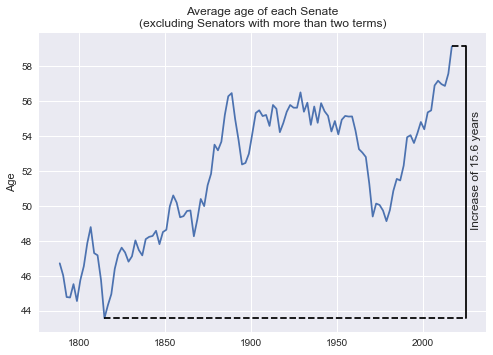

In [448]:
fig, axis = plt.subplots(1)

axis.plot(congress_date_new, avg_ages_new)

axis.set_ylabel('Age')

where_min = np.argmin(avg_ages_new)
where_max = np.argmax(avg_ages_new)

axis.plot([congress_date_new[where_min], 2025], [avg_ages_new[where_min], avg_ages_new[where_min]],
          linestyle='--', color='black')
axis.plot([congress_date_new[where_max], 2025], [avg_ages_new[where_max], avg_ages_new[where_max]],
          linestyle='--', color='black')

axis.plot([2025, 2025], [avg_ages_new[where_max], avg_ages_new[where_min]], color='black')
axis.text(2028, 55, "Increase of {:1.1f} years".format((avg_ages_new.max() - avg_ages_new.min())),
          rotation=90)

axis.set_title('Average age of each Senate\n(excluding Senators with more than two terms)')
fig.savefig('avg_age_of_two_term_senate.jpeg', dpi=100)

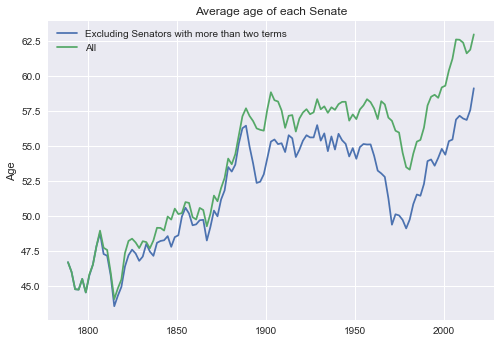

In [469]:
fig, axis = plt.subplots(1)

axis.plot(congress_date_new, avg_ages_new, label='Excluding Senators with more than two terms')
axis.plot(congress_date, avg_ages, label='All')

axis.set_ylabel('Age')
axis.legend()

axis.set_title('Average age of each Senate')
fig.savefig('avg_age_senate_compare.jpeg', dpi=100)